In [1]:
#Implementing Linear Regression on the preprocessed dataset, while showing the best outlier handling methods.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import joblib

In [2]:
train = pd.read_csv("../data/train_OneHot.csv")
train = train.drop("Id", axis=1)

# Separate features and target
yTrain = train["HotelValue"]
xTrain = train.drop("HotelValue", axis=1)

skewness = yTrain.skew()   
print("Skewness:", skewness)
print("Shape before dealing with outliers: ", xTrain.shape, ", ", yTrain.shape )

Skewness: 1.726037528148192
Shape before dealing with outliers:  (1200, 301) ,  (1200,)


In [3]:
# Method 1: Trim top 5% for right-skew
upper_5 = yTrain.quantile(0.95)
mask1 = yTrain <= upper_5
xTrain1 = xTrain[mask1]
yTrain1 = yTrain[mask1]
print("Shape after trimming: ", xTrain1.shape, ", ", yTrain1.shape )
xSub1, xVal1, ySub1, yVal1 = train_test_split(xTrain1, yTrain1, test_size=0.2, random_state=42)

alpha_linear = 0.05
RidgeTuning_trim = dict()
while alpha_linear <= 200:
    model = Ridge(alpha=alpha_linear, max_iter=100000)
    model.fit(xSub1, ySub1)
    yPred = model.predict(xVal1)
    rmse = root_mean_squared_error(yVal1, yPred)
    RidgeTuning_trim[round(alpha_linear, 3)] = rmse
    alpha_linear += 0.05
best_alpha_trim = min(RidgeTuning_trim, key=RidgeTuning_trim.get)
min_rmse_trim = RidgeTuning_trim[best_alpha_trim]
print("Trim method - Best alpha:", best_alpha_trim, "RMSE:", min_rmse_trim)

Shape after trimming:  (1140, 301) ,  (1140,)
Trim method - Best alpha: 53.5 RMSE: 27308.994938318236


In [14]:
Q1 = yTrain.quantile(0.25)
Q3 = yTrain.quantile(0.75)
IQR = Q3 - Q1
lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 3 * IQR
mask2 = (yTrain >= lower_iqr) & (yTrain <= upper_iqr)
xTrain2 = xTrain[mask2]
yTrain2 = yTrain[mask2]
print("Shape after IQR: ", xTrain2.shape, ", ", yTrain2.shape )
xSub2, xVal2, ySub2, yVal2 = train_test_split(xTrain2, yTrain2, test_size=0.2, random_state=42)

alpha_linear = 0.05
RidgeTuning_iqr = dict()
while alpha_linear <= 200:
    model = Ridge(alpha=alpha_linear, max_iter=100000)
    model.fit(xSub2, ySub2)
    yPred = model.predict(xVal2)
    rmse = root_mean_squared_error(yVal2, yPred)
    RidgeTuning_iqr[round(alpha_linear, 3)] = rmse
    alpha_linear += 0.05
best_alpha_iqr = min(RidgeTuning_iqr, key=RidgeTuning_iqr.get)
min_rmse_iqr = RidgeTuning_iqr[best_alpha_iqr]
print("IQR method - Best alpha:", best_alpha_iqr, "RMSE:", min_rmse_iqr)

Shape after IQR:  (1192, 301) ,  (1192,)
IQR method - Best alpha: 0.05 RMSE: 23985.76453641107


In [5]:
xSub3, xVal3, ySub3, yVal3 = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

alpha_linear = 0.05
RidgeTuning_none = dict()
while alpha_linear <= 200:
    model = Ridge(alpha=alpha_linear, max_iter=100000)
    model.fit(xSub3, ySub3)
    yPred = model.predict(xVal3)
    rmse = root_mean_squared_error(yVal3, yPred)
    RidgeTuning_none[round(alpha_linear, 3)] = rmse
    alpha_linear += 0.05
best_alpha_none = min(RidgeTuning_none, key=RidgeTuning_none.get)
min_rmse_none = RidgeTuning_none[best_alpha_none]
print("No outlier removal - Best alpha:", best_alpha_none, "RMSE:", min_rmse_none)

No outlier removal - Best alpha: 11.75 RMSE: 26907.976689662995


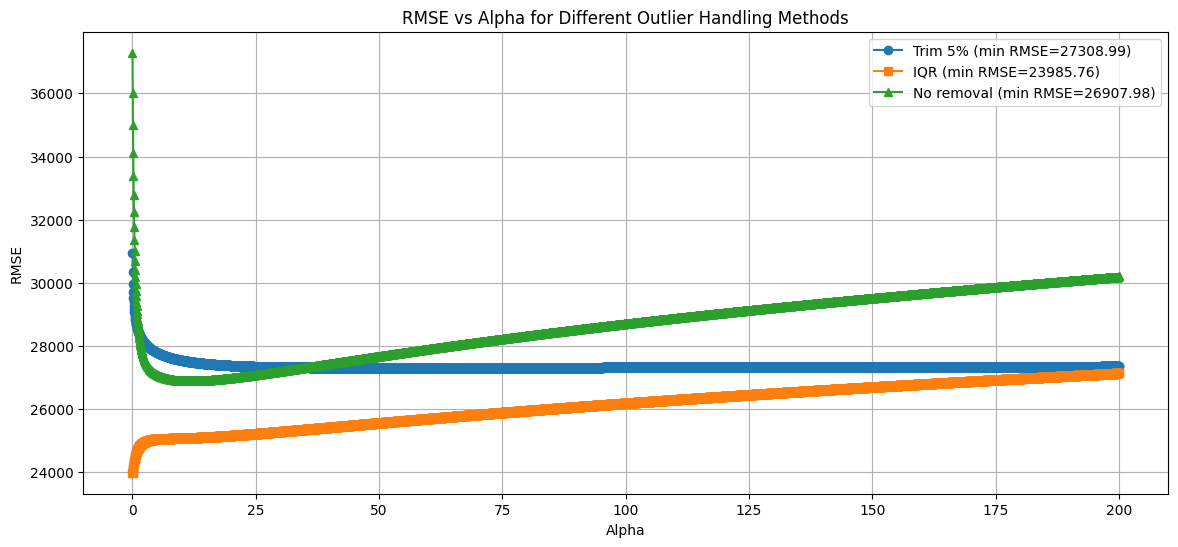

In [15]:
plt.figure(figsize=(14,6))
plt.plot(list(RidgeTuning_trim.keys()), list(RidgeTuning_trim.values()), marker='o', label=f'Trim 5% (min RMSE={min_rmse_trim:.2f})')
plt.plot(list(RidgeTuning_iqr.keys()), list(RidgeTuning_iqr.values()), marker='s', label=f'IQR (min RMSE={min_rmse_iqr:.2f})')
plt.plot(list(RidgeTuning_none.keys()), list(RidgeTuning_none.values()), marker='^', label=f'No removal (min RMSE={min_rmse_none:.2f})')
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("RMSE vs Alpha for Different Outlier Handling Methods")
plt.grid(True)
plt.legend()
plt.show()

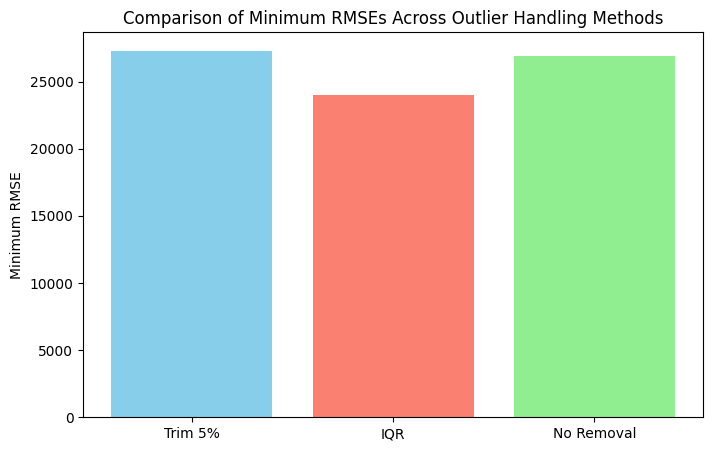

In [16]:
plt.figure(figsize=(8,5))
methods = ['Trim 5%', 'IQR', 'No Removal']
min_rmses = [min_rmse_trim, min_rmse_iqr, min_rmse_none]
plt.bar(methods, min_rmses, color=['skyblue','salmon','lightgreen'])
plt.ylabel("Minimum RMSE")
plt.title("Comparison of Minimum RMSEs Across Outlier Handling Methods")
plt.show()

In [8]:
# Fit the best model on the entire IQR-cleaned dataset
best_ridge_model = Ridge(alpha=best_alpha_iqr, max_iter=100000)
best_ridge_model.fit(xTrain2, yTrain2)

# Save the model to disk
joblib.dump(best_ridge_model, "best_ridge_iqr_model.pkl")
print("Best Ridge model saved as 'best_ridge_iqr_model.pkl'.")


Best Ridge model saved as 'best_ridge_iqr_model.pkl'.
